<a href="https://colab.research.google.com/github/deepenmi/GenerativeAdversarialNetwork-Practice/blob/master/Autoencoders_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np




import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf


In [0]:
batch_size = 100
original_dim = 28*28              # size of image
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5                      # Number of epoch
epsilon_std = 1.0

In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
  return z_mean + K.exp(z_log_var/2) * epsilon

# Creating the encoder


In [53]:
# Input to our encoder
x = Input(shape=(original_dim,), name="input")
# Intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# Defines the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# Defines the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defines encoder as a keras model
encoder = Model(x,[z_mean,z_log_var,z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

# Writing the decoder

In [54]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")   
# Takes the latent space to the intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# Gets the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)     
# Defines the decoder as a Keras model                               
decoder = Model(input_decoder, x_decoded, name="decoder")   
decoder.summary() 

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


# Combine the model - encoder and decoder into a single VAE model (variational autoencoder)

In [55]:
# Grabs the output. Recall that we need to grab the third element, our sampling z.
output_combined = decoder(encoder(x)[2])      

# Links the input and the overall output
vae = Model(x, output_combined)    

# Prints out what the overall model looks like
vae.summary()



Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Define the loss and rin the model

In [74]:

def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Creating the train/test split 

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [76]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 197us/step - loss: 156.7105 - val_loss: 155.8869
Epoch 2/5
60000/60000 [==============================] - 11s 185us/step - loss: 155.4955 - val_loss: 155.8913
Epoch 3/5
60000/60000 [==============================] - 11s 181us/step - loss: 154.6735 - val_loss: 154.5368
Epoch 4/5
60000/60000 [==============================] - 11s 181us/step - loss: 153.9146 - val_loss: 154.0177
Epoch 5/5
60000/60000 [==============================] - 11s 179us/step - loss: 153.2933 - val_loss: 153.5091


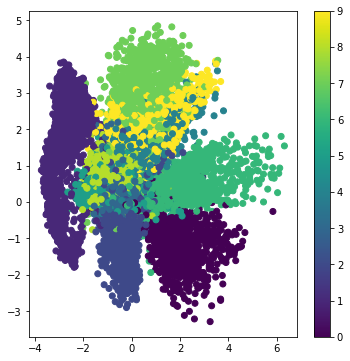

In [77]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

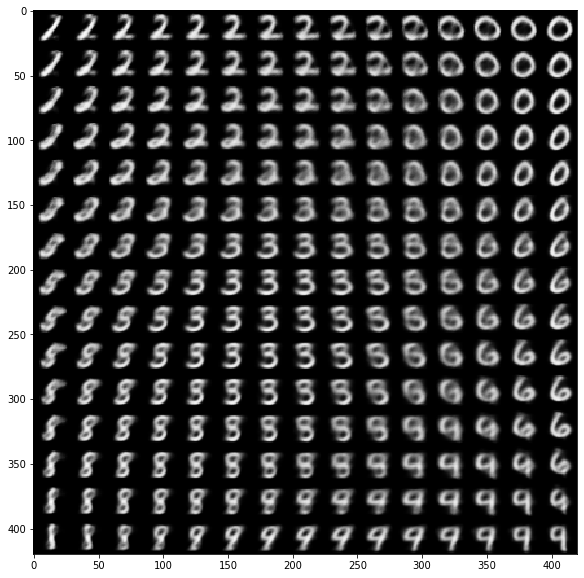

In [78]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()